In [17]:
import numpy as np
%matplotlib inline

from examples.seismic import demo_model, plot_velocity, plot_perturbation

from devito import configuration
configuration['log-level'] = 'WARNING' # This added simply to reduce clutter in the output

# This cell consists a set of useful imports. Feel free to modify if you need anything else or would like
# remove a redundant import.

import time
import numpy as np
from scipy.ndimage import gaussian_filter # This filter will be used to generate the smoothed model
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver, TimeAxis
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord
from examples.seismic import RickerSource
from examples.seismic import TimeAxis
from mpl_toolkits.axes_grid1 import make_axes_locatable
from examples.seismic import Model, plot_velocity
import time as pytime
from devito import TimeFunction
from devito import Eq, solve

# Reduce the level of output printed by Devito
from devito import configuration
configuration['log-level'] = 'WARNING'

## Define the full ricker wavelet which is the same as in Spyro

In [ ]:
# def wavelet(self):
#     t0 = self.t0 or 1 / self.f0
#     a = self.a or 1
#     r = (np.pi * self.f0 * (self.time_values - t0))
#     return a * (1-2.*r**2)*np.exp(-r**2)


import math

# Definition of wavelet from Spyro
def full_ricker_wavelet(
    dt,
    final_time,
    frequency,
    amplitude=1.0,
    cutoff=None,
    delay=1.5,
    delay_type="multiples_of_minimun",
):
    """Compute the Ricker wavelet optionally applying low-pass filtering
    using cutoff frequency in Hertz.

    Parameters
    ----------
    dt: float
        Time step
    final_time: float
        Final time
    frequency: float
        Frequency of the wavelet
    amplitude: float
        Amplitude of the wavelet
    cutoff: float
        Cutoff frequency in Hertz
    delay: float
        Delay in term of multiples of the distance
        between the minimums.
    delay_type: string
        Type of delay. Options are:
        - multiples_of_minimun
        - time

    Returns
    -------
    list of float
        list of ricker values at each time step
    """
    nt = int(final_time / dt) + 1  # number of timesteps
    time = 0.0
    full_wavelet = np.zeros((nt,))
    for t in range(nt):
        full_wavelet[t] = ricker_wavelet(
            time, frequency, amplitude, delay=delay, delay_type=delay_type
        )
        time += dt
    if cutoff is not None:
        fs = 1.0 / dt
        order = 2
        nyq = 0.5 * fs  # Nyquist Frequency
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients
        b, a = butter(order, normal_cutoff, btype="low", analog=False)
        full_wavelet = filtfilt(b, a, full_wavelet)
    return full_wavelet

# Forward modeling

## 0. Zero example: One layer simple velocity model
### 1. Set up velocity model

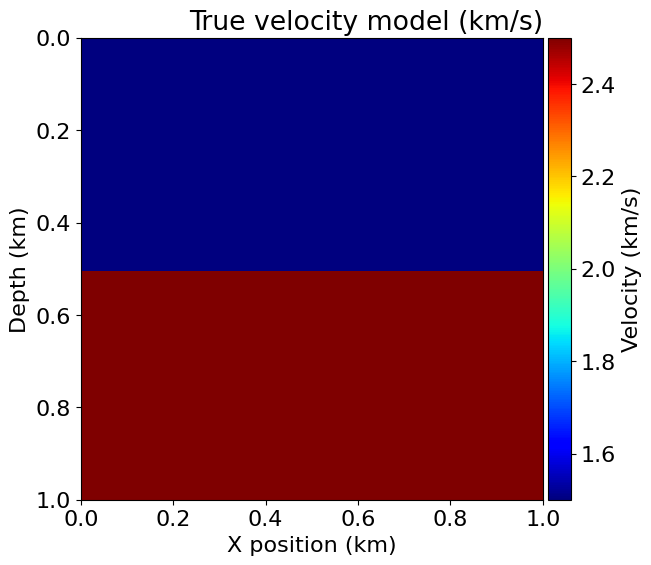

In [101]:
# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

nbl = 40
# With the velocity and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nbl, bcs="damp")

plt.title('True velocity model (km/s)', loc='right')
plot_velocity(model)

### 2. Acquisition geometry

In [102]:
t0 = 0.  # Simulation starts a t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt  # Time step from model grid spacing
f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
time_range = TimeAxis(start=t0, stop=tn, step=dt)

In [103]:
# def wavelet(self):
#     t0 = self.t0 or 1 / self.f0
#     a = self.a or 1
#     r = (np.pi * self.f0 * (self.time_values - t0))
#     return a * (1-2.*r**2)*np.exp(-r**2)


import math

# Definition of wavelet from Spyro
def full_ricker_wavelet(
    dt,
    final_time,
    frequency,
    amplitude=1.0,
    cutoff=None,
    delay=1.5,
    delay_type="multiples_of_minimun",
):
    """Compute the Ricker wavelet optionally applying low-pass filtering
    using cutoff frequency in Hertz.

    Parameters
    ----------
    dt: float
        Time step
    final_time: float
        Final time
    frequency: float
        Frequency of the wavelet
    amplitude: float
        Amplitude of the wavelet
    cutoff: float
        Cutoff frequency in Hertz
    delay: float
        Delay in term of multiples of the distance
        between the minimums.
    delay_type: string
        Type of delay. Options are:
        - multiples_of_minimun
        - time

    Returns
    -------
    list of float
        list of ricker values at each time step
    """
    nt = int(final_time / dt) + 1  # number of timesteps
    time = 0.0
    full_wavelet = np.zeros((nt,))
    for t in range(nt):
        full_wavelet[t] = ricker_wavelet(
            time, frequency, amplitude, delay=delay, delay_type=delay_type
        )
        time += dt
    if cutoff is not None:
        fs = 1.0 / dt
        order = 2
        nyq = 0.5 * fs  # Nyquist Frequency
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients
        b, a = butter(order, normal_cutoff, btype="low", analog=False)
        full_wavelet = filtfilt(b, a, full_wavelet)
    return full_wavelet

In [104]:
wavelet = full_ricker_wavelet(dt=dt * 0.001, final_time=1.0, frequency=10.0)

In [159]:
print(wavelet.shape)
# print(wavelet)

(409,)


In [144]:
# 创建源
src = TimeFunction(name='src', grid=model.grid, time_order=2, space_order=2)
# src.data[:] = full_ricker_wavelet(dt=dt * 0.001, final_time=1.0, frequency=10.0)

In [158]:
from examples.seismic import PointSource

# Create a point source with properties for the simulation
src = PointSource(name='src', grid=model.grid, time_range = time, npoint=1, data =  full_ricker_wavelet(dt=dt * 0.001, final_time=1.0, frequency=10.0))

src.data[:] = full_ricker_wavelet(dt=dt * 0.001, final_time=1.0, frequency=10.0)

# Set the location of the source in the middle of the grid
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

print(src.coordinates.data)
print(src.data.shape)
print(src.data)

[[500.  20.]]
(410, 1)
[[-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.5644935e-05]
 [-3.

In [155]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

print(src.coordinates.data)
print(src.data.shape)

# # We can plot the time signature to see the wavelet
# src.show()

[[500.  20.]]
(410, 1)


In [136]:
src

src(time, p_src)

In [137]:
src.coordinates.data

Data([[500.,  20.]], dtype=float32)

In [140]:
src.data.shape

(410, 1)

In [119]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# # We can now show the source and receivers within our domain:
# # Red dot: Source location
# # Green dots: Receiver locations (every 4th point)
# plot_velocity(model, source=src.coordinates.data,
#               receiver=rec.coordinates.data[::4, :])

In [120]:
rec.data

Data([[0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.],
      ...,
      [0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.],
      [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [121]:
rec.coordinates.data

Data([[0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0., 0.],
      [0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


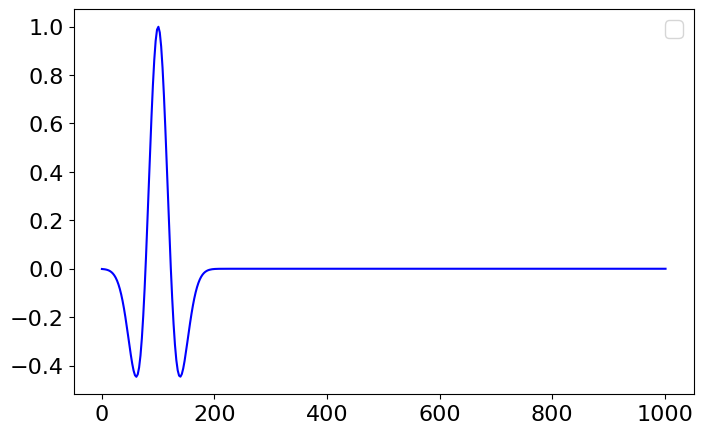

In [74]:
# wavelet = src.data

# plt.figure(figsize=(8, 5))
# plt.plot(np.arange(wavelet.shape[0]) * dt, wavelet, color='blue', linewidth=1.5 )
# plt.legend()
# plt.show()

In [75]:
np.savetxt("src_devito.dat", src.data[:])

### 3. Forward modeling

In [47]:
# Define the wavefield
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2, save=time.num)

# PDE equation
pde = u.dt2 - (1/model.m) * u.laplace + (1/model.m) * model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

# Serial modeling function
def forward_modeling_single_shot(model, geometry):
    # Create Ricker source and inject into the wavefield
    src = geometry.src
    src_term = src.inject(field=u.forward, expr=src * dt**2 * model.m)

    # Create receivers and interpolate the wavefield
    rec = Receiver(name='rec', npoint=nreceivers, grid=model.grid, coordinates=rec_coordinates, time_range=time)
    rec_term = rec.interpolate(expr=u.forward)

    # Create operator and execute
    op_fwd = Operator([stencil] + src_term + rec_term)

    # Calculate running time
    start_time = pytime.time()
    op_fwd(dt=dt)
    end_time = pytime.time()
    running_time = end_time - start_time
    print(f"Running Time: {running_time:.2f} seconds")
    return rec, u

In [48]:
rec, u1 = forward_modeling_single_shot(model, geometry1)

Running Time: 0.03 seconds


In [49]:
u1.data.shape

(410, 181, 181)

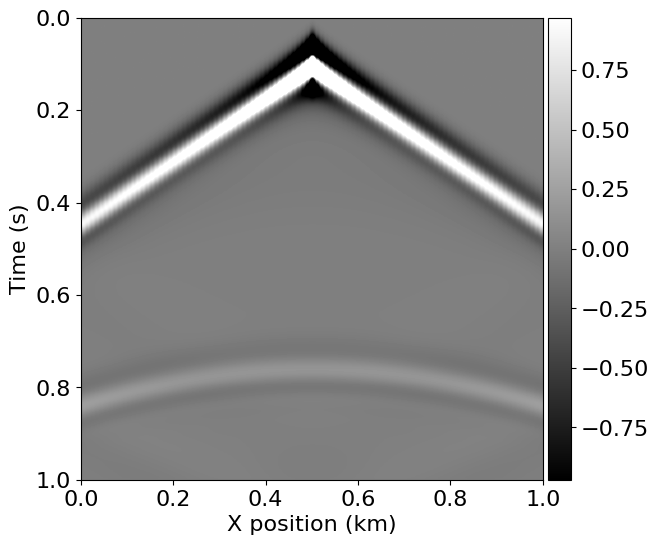

In [50]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord
plot_shotrecord(rec.data, model, t0, tn)

# Save rec1 as a .dat file
np.savetxt("rec_ex0_devito.dat", rec.data[:, :])

In [51]:
rec.data

Data([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ],
      ...,
      [-0.00813589, -0.00956805, -0.01112707, ..., -0.01112707,
       -0.00956805, -0.00813589],
      [-0.00774912, -0.00909189, -0.0105607 , ..., -0.0105607 ,
       -0.00909189, -0.00774912],
      [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ]], dtype=float32)

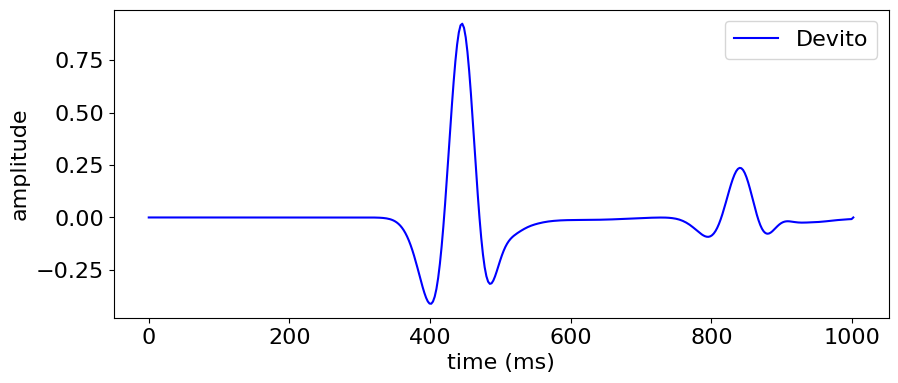

In [52]:
# Plot trace at receiver 0
plt.figure(figsize=(10,4))
plt.plot( np.arange(rec.data.shape[0]) * 2.449, rec.data[:, 0], label='Devito', color='blue')
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()

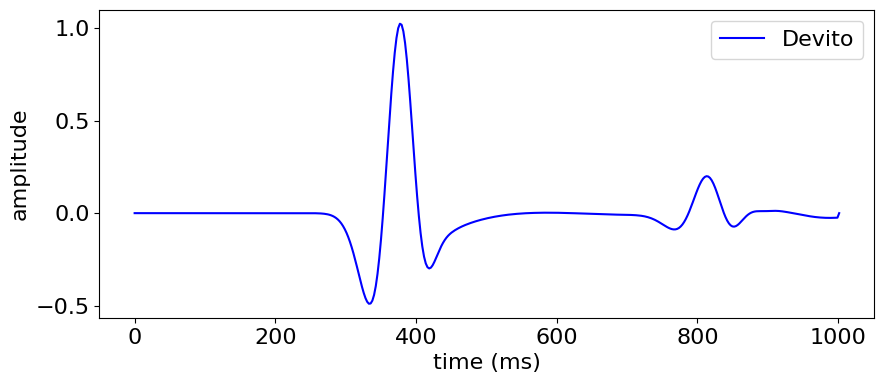

In [53]:
# Plot trace at receiver 0
plt.figure(figsize=(10,4))
plt.plot( np.arange(rec.data.shape[0]) * 2.449, rec.data[:, 10], label='Devito', color='blue')
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()

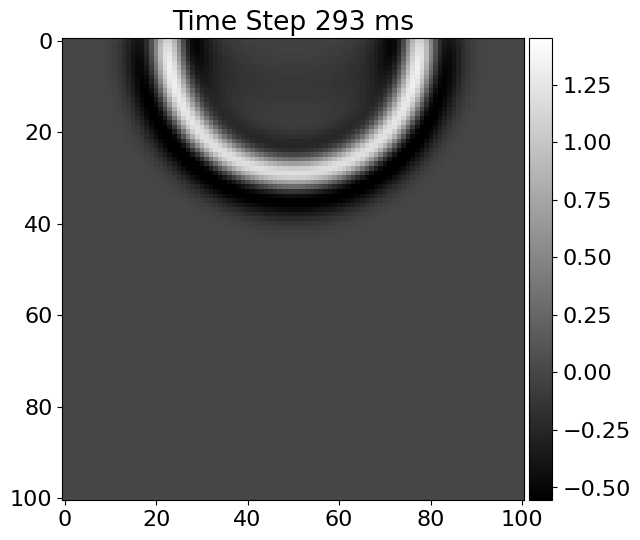

In [28]:
from examples.seismic import plot_image
time_index = 120
plt.title(f"Time Step {int(time_index * dt)} ms")
plot_image(u.data[time_index, nbl:-nbl, nbl:-nbl])

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_52887/236926137.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


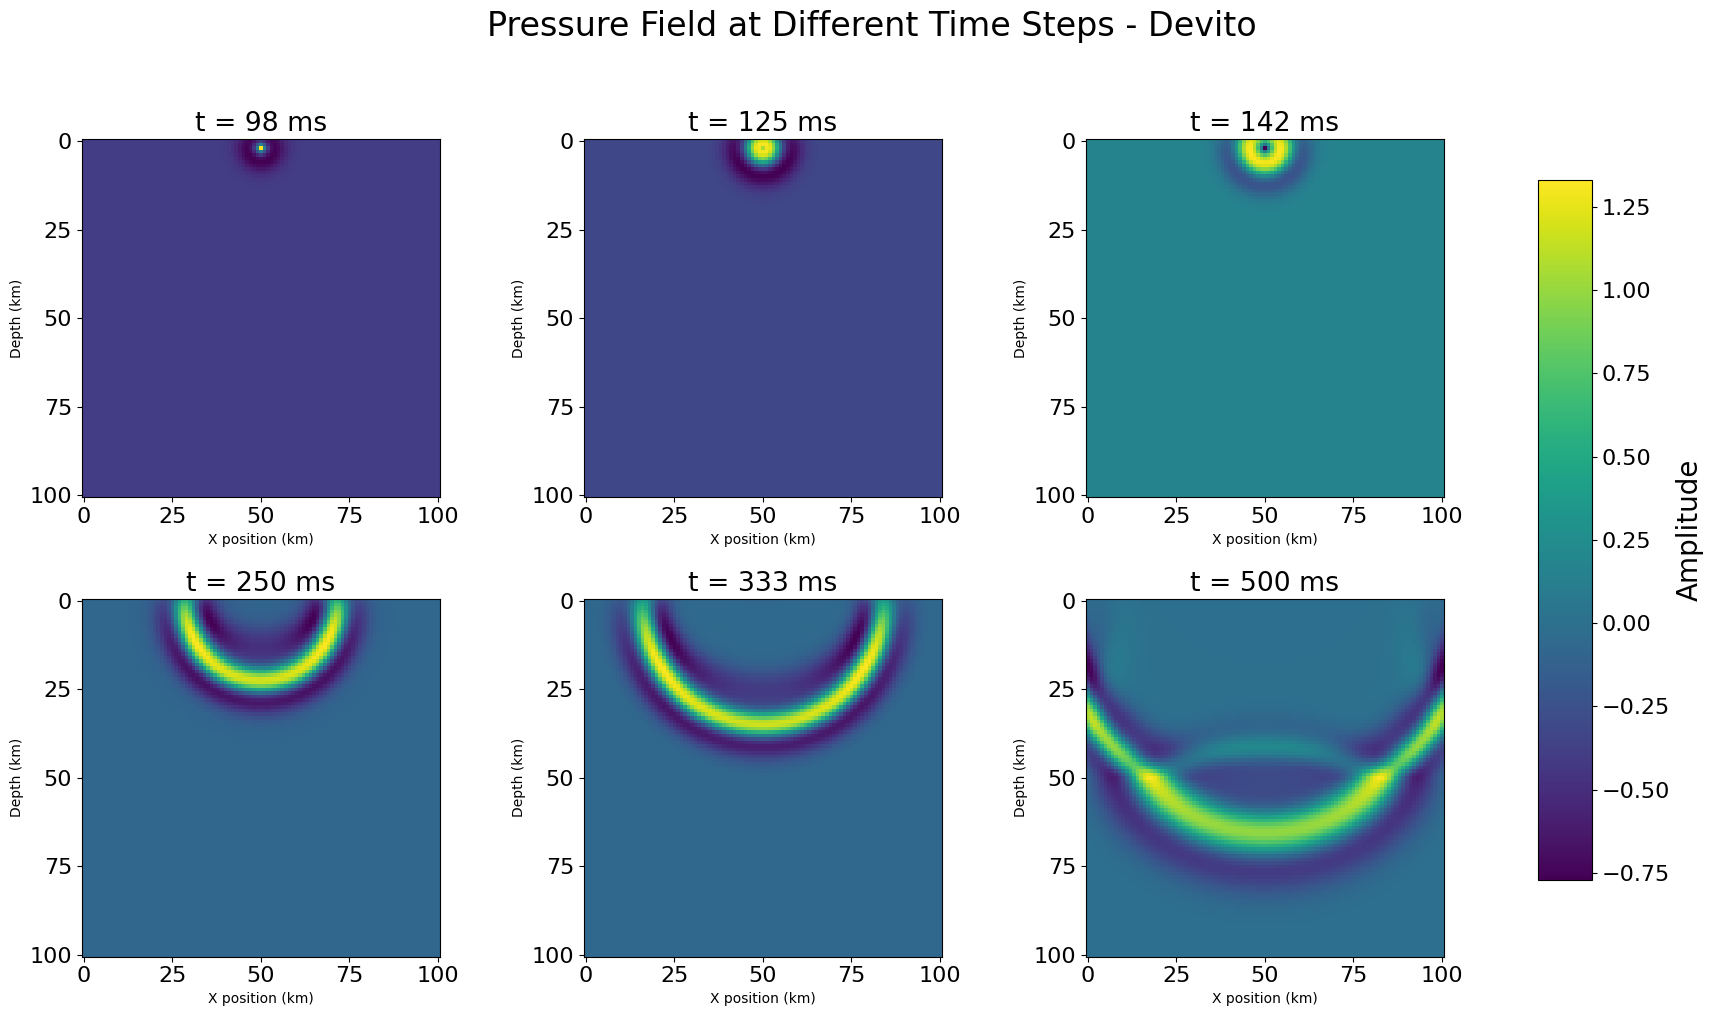

In [62]:
def plot_pressure_field(ax, model, time_step, dt, cmap='gray', vmin=-1e-3, vmax=1e-3):
    # Assuming 'u.data', 'model', and 'dt' are defined in your context
    time_index = time_step  # Specific time step you want to visualize
    extent = [model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
              model.origin[1] + 1e-3 * model.shape[1] * model.spacing[1], model.origin[1]]

    data_param = dict(vmin=vmin, vmax=vmax, aspect=1, extent=extent, interpolation='none', cmap=cmap)  # Parameters including gray scale
    
    nbl = 10
    # Plotting the pressure field at the specific time step
    im = ax.imshow(np.transpose(u.data[time_index, nbl:-nbl, nbl:-nbl]))
    # ax.invert_yaxis()
    ax.set_ylabel('Depth (km)', fontsize=14)
    ax.set_xlabel('X position (km)', fontsize=14)
    ax.set_title(f"Time Step {int(time_index * dt)} ms")  # Adjust title to show time in ms
    return im

# Assume the model, time axis, and wavefield data are properly defined
tmax = time.num - 1
times = [int(tmax/10), int(tmax/8), int(tmax/7), int(tmax/4), int(tmax/3), int(tmax/2)]

# Set the overall size of the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Create six subplots
for i, ax in enumerate(axes.flat):
    im = plot_pressure_field(ax, model, times[i], dt)
    ax.set_xlabel('X position (km)', fontsize=10)
    ax.set_ylabel('Depth (km)', fontsize=10)
    ax.set_title(f"t = {times[i] * dt:.0f} ms")
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    xticks = np.linspace(0, model.domain_size[0]/spacing[0], num=5)
    yticks = np.linspace(0, model.domain_size[1]/spacing[1], num=5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    ax.set_yticklabels([f"{int(y)}" for y in yticks])

# Add a unified colorbar
fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.005)
cbar.set_label('Amplitude', fontsize=20)

fig.suptitle('Pressure Field at Different Time Steps - Devito', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show() 

In [11]:
# times
dt

2.449

## I. First example: simple circle velocity with single source

In case to comparable with Spyro. The acoustic wave equation with this damping mask where $m = c^2$ can be rewritten as:
\begin{equation} 
  \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \frac{1}{m}\nabla^2 u(\mathbf{x},t) +  \frac{1}{m} \eta \frac{\partial u(\mathbf{x},t)}{\partial t}=\frac{q}{m}
\end{equation}

Moreover, to make the numerical solution from Devito comparable with Spyro, it needs to be scaled by ${dx^2}$(where dx is the grid spacing from Devito).
As demonstrated in this Devito tutorial (https://slimgroup.github.io/Devito-Examples/tutorials/accuracy/), this scaling is also necessary when comparing with the forward analytical solution.
### 1. Set up velocity model

In [38]:
# Define true and initial model
shape = (501, 501)  # Number of grid point (nx, nz)
spacing = (2., 2.)  # Grid spacing in m. The domain size is now 1km by 1km (lx,ly)
origin = (0., 0.)  # Need origin to define relative source and receiver locations

#Set the number of boundary layers 
nbl = 200

v = np.full(shape, 2.5, dtype=np.float32)  # intial speed is 2.5 km/s
center_x, center_y = shape[0] // 2, shape[1] // 2  # center of circle
radius = 75  # raduis is 300m = 0.3km

for x in range(shape[0]):
    for y in range(shape[1]):
        if (x - center_x) ** 2 + (y - center_y) ** 2 <= radius ** 2:
            v[x, y] = 3.0

#True Vp model
model1 = Model(vp=v, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=nbl, bcs="damp")

#Smoothed Vp model
v1 = np.full(shape, 2.5, dtype=np.float32)  # 2.5 km/s
model0 = Model(vp=v1, origin=origin, shape=shape, spacing=spacing, space_order=2, nbl=nbl, bcs="damp")

In [39]:
print("domain size:", model1.domain_size)
print("origin point:", model1.origin)

domain size: (1000.0, 1000.0)
origin point: (0.0, 0.0)


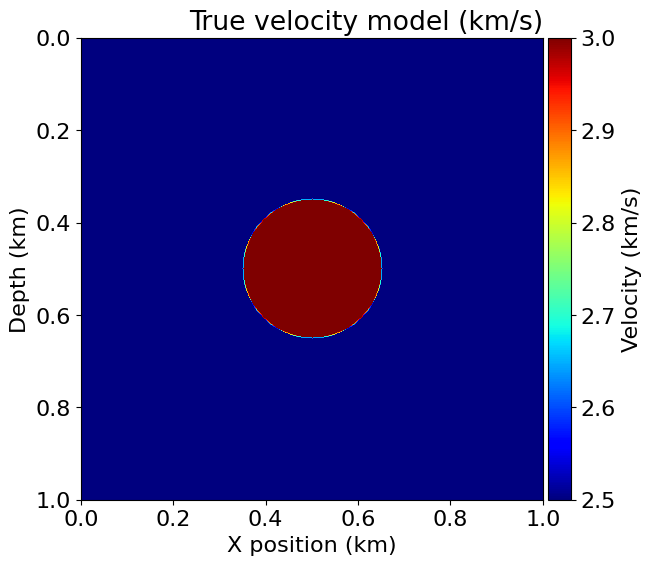

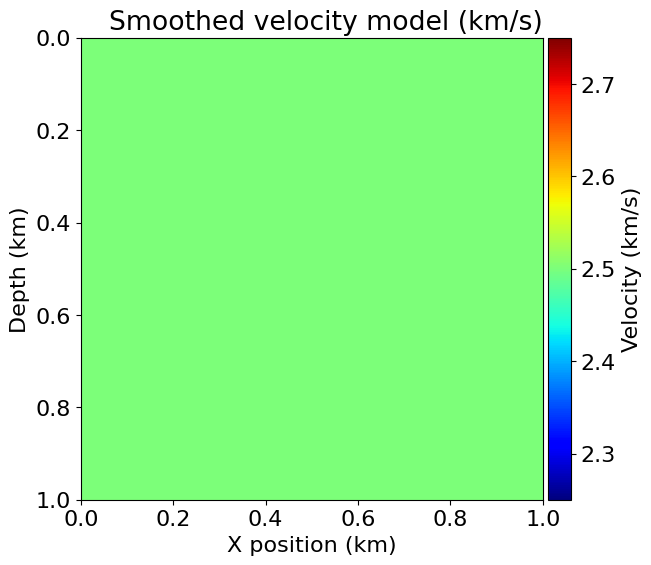

In [40]:
# Quick plot of model.
plt.title('True velocity model (km/s)', loc='right')
plot_velocity(model1)
plt.title('Smoothed velocity model (km/s)', loc='right')
plot_velocity(model0)

### 2. Acquisition geometry

In [41]:
# Set up source geometry, only one source
nsources = 1
src_coordinates = np.empty((nsources, 2))
src_coordinates[0, 1] = np.array(model1.domain_size[1]) * .5
src_coordinates[0, 0] = 20.

# # Set up source geometry, but define 5 sources instead of just one.
# nsources = 5
# src_coordinates = np.empty((nsources, 2))
# src_coordinates[:, 1] = np.linspace(0, model1.domain_size[0], num=nsources)
# src_coordinates[:, 0] = 20.  # Source depth is 20m

# Initialize receivers for synthetic and imaging data
nreceivers = 101
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model1.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Create the Geometry
t0 = 0.
tn = 1000. # 1000ms
f0 = 0.010 # 10Hz (=0.01 kHz)
dt = model1.critical_dt
time = TimeAxis(start=t0, stop=tn, step=dt)
# Set up geometry objects for observed and predicted data
geometry1 = AcquisitionGeometry(model1, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
geometry0 = AcquisitionGeometry(model0, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

# Define the wavefield
u = TimeFunction(name="u", grid=model1.grid, time_order=2, space_order=2, save=time.num)

# PDE equation
pde = u.dt2 - (1/model1.m) * u.laplace + (1/model1.m) * model1.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping


In [42]:
rec_coordinates

array([[ 980.,    0.],
       [ 980.,   10.],
       [ 980.,   20.],
       [ 980.,   30.],
       [ 980.,   40.],
       [ 980.,   50.],
       [ 980.,   60.],
       [ 980.,   70.],
       [ 980.,   80.],
       [ 980.,   90.],
       [ 980.,  100.],
       [ 980.,  110.],
       [ 980.,  120.],
       [ 980.,  130.],
       [ 980.,  140.],
       [ 980.,  150.],
       [ 980.,  160.],
       [ 980.,  170.],
       [ 980.,  180.],
       [ 980.,  190.],
       [ 980.,  200.],
       [ 980.,  210.],
       [ 980.,  220.],
       [ 980.,  230.],
       [ 980.,  240.],
       [ 980.,  250.],
       [ 980.,  260.],
       [ 980.,  270.],
       [ 980.,  280.],
       [ 980.,  290.],
       [ 980.,  300.],
       [ 980.,  310.],
       [ 980.,  320.],
       [ 980.,  330.],
       [ 980.,  340.],
       [ 980.,  350.],
       [ 980.,  360.],
       [ 980.,  370.],
       [ 980.,  380.],
       [ 980.,  390.],
       [ 980.,  400.],
       [ 980.,  410.],
       [ 980.,  420.],
       [ 98

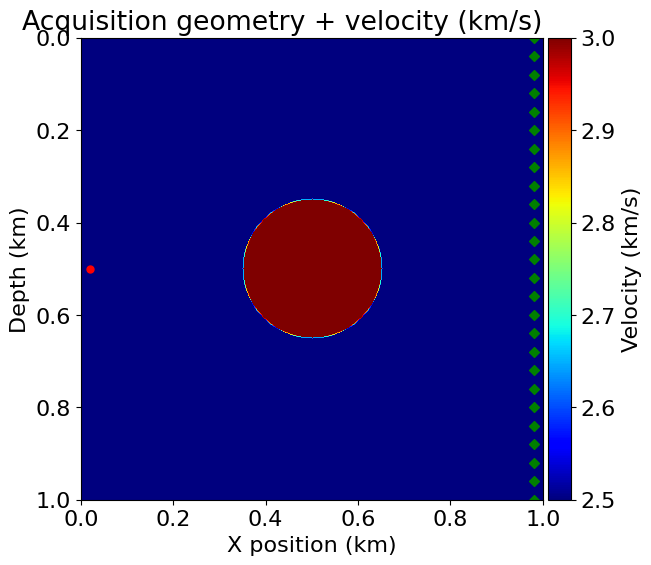

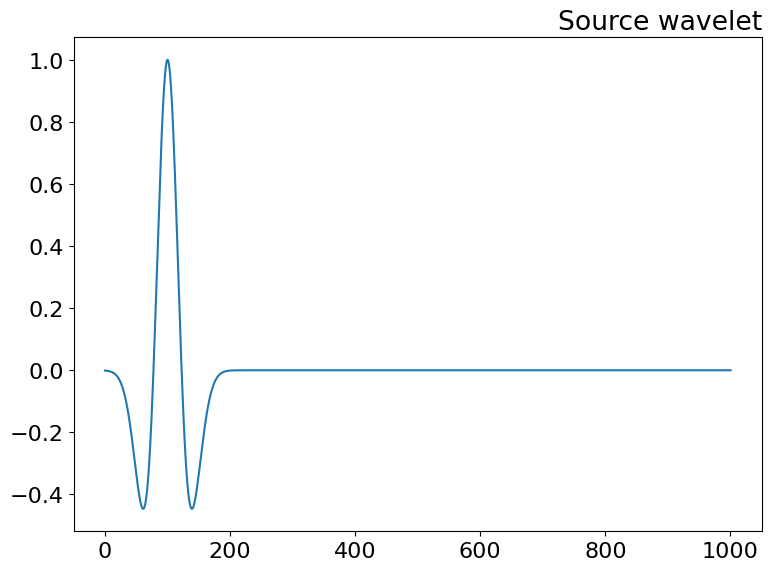

In [43]:
# Plot acquisition geometry overlaid with true Vp
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plot_velocity(model1, source=src_coordinates, receiver=rec_coordinates[::4]); # Plot every one in four receivers.

# Plot source wavelet
plt.plot(geometry0.src.time_values, geometry0.src.data[:, 0])
plt.title('Source wavelet', loc='right')
plt.tight_layout(); plt.show()

### 3. Forward modeling

In [44]:
import time as pytime
# Serial modeling function
def forward_modeling_single_shot(model, geometry):
    # Create Ricker source and inject into the wavefield
    src = geometry.src
    src_term = src.inject(field=u.forward, expr=src * dt**2 * model.m)

    # Create receivers and interpolate the wavefield
    rec = Receiver(name='rec', npoint=nreceivers, grid=model.grid, coordinates=rec_coordinates, time_range=time)
    rec_term = rec.interpolate(expr=u.forward)

    # Create operator and execute
    op_fwd = Operator([stencil] + src_term + rec_term)

    # Calculate running time
    start_time = pytime.time()
    op_fwd(dt=dt)
    end_time = pytime.time()
    running_time = end_time - start_time
    print(f"Running Time: {running_time:.2f} seconds")
    return rec, u

In [45]:
rec, u1 = forward_modeling_single_shot(model1, geometry1)

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on ph

Running Time: 3.93 seconds


### 4. Plot the shot records

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00032978 0.0003311  0.00032863 ... 0.00032863 0.0003311  0.00032978]
 [0.00033102 0.00033202 0.00032923 ... 0.00032923 0.00033202 0.00033102]
 [0.00033223 0.00033289 0.00032977 ... 0.00032977 0.00033289 0.00033223]]
(2450, 101)
min: -0.0026107552
max: 0.0053324145
(2451, 901, 901)


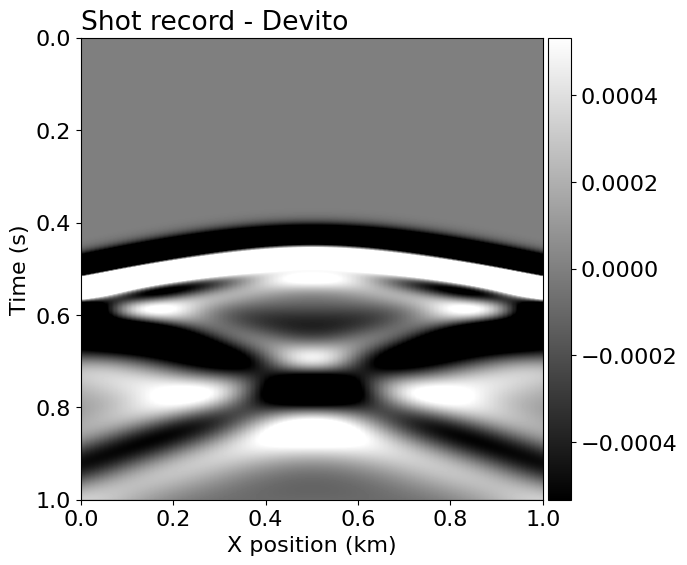

In [46]:
rec1 = rec.data 
# rec1 = rec.data * (1/(model1.spacing[0]**2))
print(rec1[:-1, :])
print(rec1[:-1, :].data.shape)
print("min:",np.min(rec1))
print("max:",np.max(rec1))
print(u.data.shape)

plt.title('Shot record - Devito', loc='left')
plot_shotrecord(rec1, model1, t0, tn)
# Save rec1 as a .dat file
np.savetxt("rec_ex1_devito.dat", rec1[:-1, :])

In [ ]:
# Plot trace at receiver 0
plt.figure(figsize=(10,4))
plt.plot( np.arange(rec.data.shape[0]) * 2.449, rec.data[:, 0], label='Devito', color='blue')
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()

### 4.1 trying something parallel but not working now

In [47]:
# # Parallel modeling function
# def forward_modeling_multi_shots(model, geometry):

#     futures = []
#     for i in range(geometry.nsrc):

#         # Geometry for current shot
#         geometry_i = AcquisitionGeometry(model, geometry.rec_positions, geometry.src_positions[i,:], 
#             geometry.t0, geometry.tn, f0=geometry.f0, src_type=geometry.src_type)
        
#         # Call serial modeling function for each index
#         futures.append(client.submit(forward_modeling_single_shot, model, geometry_i))

#     # Wait for all workers to finish and collect shots
#     wait(futures)
#     shots = []
#     for i in range(geometry.nsrc):
#         shots.append(futures[i].result()[0])

#     return shots


# from distributed import Client, wait
# USE_GPU_AWARE_DASK = False

# # Start Dask cluster
# if USE_GPU_AWARE_DASK:
#     from dask_cuda import LocalCUDACluster
#     cluster = LocalCUDACluster(threads_per_worker=1, death_timeout=600) 
# else:
#     from distributed import LocalCluster
#     cluster = LocalCluster(n_workers=nsources, death_timeout=600)
    
# client = Client(cluster)

# # Compute observed data in parallel (inverse crime). In real life we would read the SEG-Y data here.
# d_obs = forward_modeling_multi_shots(model1, geometry1)

### 5. Plot the pressure fields

In [49]:
u.data.shape

(2451, 901, 901)

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_52887/3955800747.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


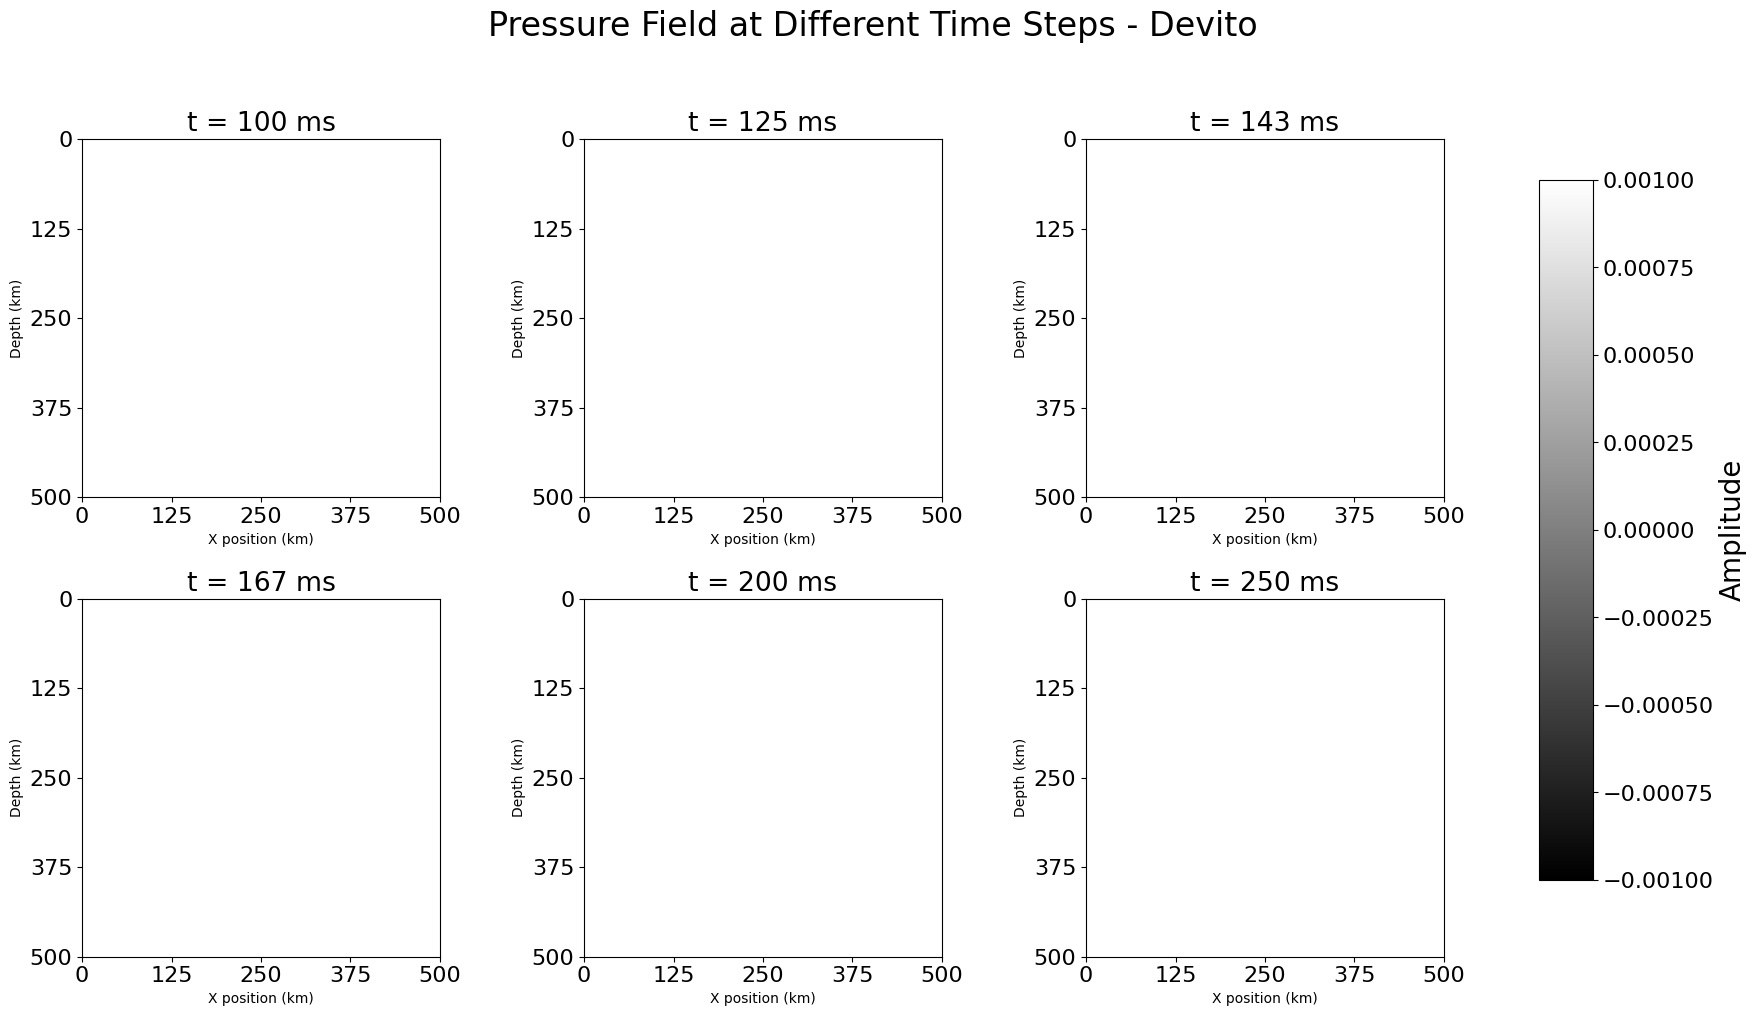

In [48]:
def plot_pressure_field(ax, model, time_step, dt, cmap='gray', vmin=-1e-3, vmax=1e-3):
    # Assuming 'u.data', 'model', and 'dt' are defined in your context
    time_index = time_step  # Specific time step you want to visualize
    extent = [model.origin[0], model.origin[0] + 1e-3 * model.shape[0] * model.spacing[0],
              model.origin[1] + 1e-3 * model.shape[1] * model.spacing[1], model.origin[1]]

    data_param = dict(vmin=vmin, vmax=vmax, aspect=1, extent=extent, interpolation='none', cmap=cmap)  # Parameters including gray scale

    # Plotting the pressure field at the specific time step
    im = ax.imshow(np.transpose(u.data[time_index, 200:-200, 200:-200]), **data_param)
    # ax.invert_yaxis()
    ax.set_ylabel('Depth (km)', fontsize=14)
    ax.set_xlabel('X position (km)', fontsize=14)
    ax.set_title(f"Time Step {int(time_index * dt)} ms")  # Adjust title to show time in ms
    return im

# Assume the model, time axis, and wavefield data are properly defined
tmax = time.num - 1
times = [int(tmax/10), int(tmax/8), int(tmax/7), int(tmax/6), int(tmax/5), int(tmax/4)]

# Set the overall size of the figure
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Create six subplots
for i, ax in enumerate(axes.flat):
    im = plot_pressure_field(ax, model1, times[i], dt)
    ax.set_xlabel('X position (km)', fontsize=10)
    ax.set_ylabel('Depth (km)', fontsize=10)
    ax.set_title(f"t = {times[i] * dt:.0f} ms")
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    xticks = np.linspace(0, model1.domain_size[0]/spacing[0], num=5)
    yticks = np.linspace(0, model1.domain_size[1]/spacing[1], num=5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    ax.set_yticklabels([f"{int(y)}" for y in yticks])

# Add a unified colorbar
fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.005)
cbar.set_label('Amplitude', fontsize=20)

fig.suptitle('Pressure Field at Different Time Steps - Devito', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show() 

#### 5. 1 Plot the single pressure field 

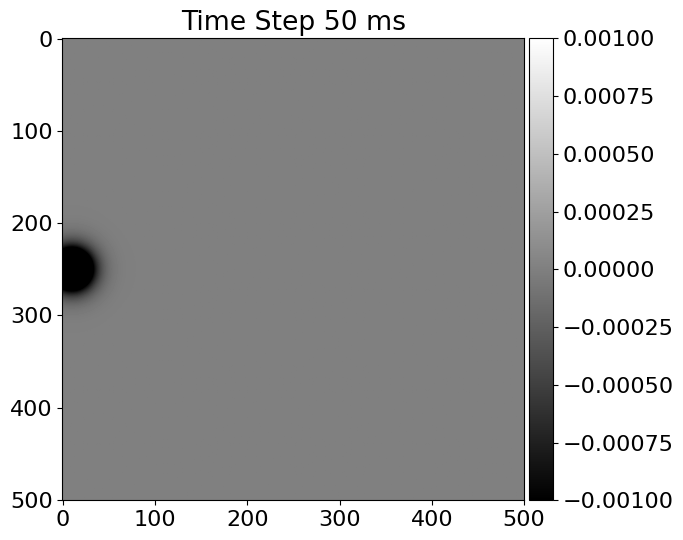

In [162]:
from examples.seismic import plot_image
time_index = 123
plt.title(f"Time Step {int(time_index * dt)} ms")
plot_image(u.data[time_index, nbl:-nbl, nbl:-nbl], cmap="gray", vmin=-1e-3, vmax=1e-3)

# II. Second Example: Marmousi Model 2D


### 1. Set up velocity models
smoothed:
3 sources \
101 receivers \
mesh $3.5km \times 10.0km$ \
pml = 0.9 km = $ 90 \times 10m$  \
Ricker : feq = 5 HZ ||  f0 = 0.005kHz \
tf = 2s, dt=0.001s || tn = 2000ms , dt = 1 ms


true:
3 sources \
101 receivers \
mesh $3.5km \times 10.0km$ \
pml = 0.9 km = $ 90 \times 10m$ \
Ricker : feq = 5 HZ ||  f0 = 0.005kHz \
tf = 2s, dt=0.00025s || tn = 2000ms , dt = 0.25 ms

In [88]:
# preparing velocity data
import h5py
import numpy as np

# 打开 HDF5 文件
filename = '/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_exact.hdf5'
with h5py.File(filename, 'r') as f:
    # 列出所有的 dataset
    print("Keys: %s" % f.keys())
    
    # 读取数据集
    dataset_name = 'velocity_model'
    data = f[dataset_name][()]
    # print("Data from dataset:", data)

    # 如果数据集中包含多种数据类型，可以逐个读取
    for key in f.keys():
        dataset = f[key]
        # print(f"Dataset name: {key}")
        # print("Dataset data:", dataset[()])  # 读取数据

        # 如果需要将数据转换为 numpy 数组
        data_array = np.transpose(np.array(dataset) * 1e-3)
        # print("Numpy array data:", data_array)
        print("Numpy array shape:", data_array.shape)
        data_array1 = np.array(dataset) * 1e-3
        print("array1 shape:", data_array1.shape)

v1 = data_array
v2 = np.rot90(v1)
v3_1 = data_array1

# v4 = v3[2700,-2700, :] ## to speed up calculation


# print("v4 shape:", v4.shape)
print("v3_1 shape:", v3_1.shape)

v4 = v3_1[:, 2700:-2700] ## to speed up calculation

v3 = np.rot90(v3_1[::10, ::10],k=-1)
# v3 = np.transpose(np.rot90(v3_1[::10, ::10], k=3))
print("v4:", v4.shape)
print("v3:", v3.shape)

Keys: <KeysViewHDF5 ['velocity_model']>
Numpy array shape: (15401, 3701)
array1 shape: (3701, 15401)
v3_1 shape: (3701, 15401)
v4: (3701, 10001)
v3: (1541, 371)


In [4]:
# visualize the velocity dataset

# plt.figure(figsize=(8,3),dpi=300)
# plot = plt.imshow(np.transpose(v3), animated=True, vmin=np.min(v3), vmax=np.max(v3))
# cbar = plt.colorbar(label='Velocity (km/s)')
# cbar.ax.tick_params(labelsize=10)  # 调整颜色条标签的字体大小
# plt.title('Velocity Model after transpose',fontsize=8)
# plt.xlabel('X position (km)',fontsize=7)
# plt.ylabel('Depth (km)',fontsize=7)
# plt.show()

# plt.figure(figsize = (1, 5), dpi=300)
# plot = plt.imshow(v3, animated=True, vmin=np.min(v3), vmax=np.max(v3), origin='lower', aspect='auto')
# cbar = plt.colorbar(label='Velocity (km/s)') 
# cbar.ax.tick_params(labelsize=10)  # 调整颜色条标签的字体大小
# plt.title('Velocity Model using original data',fontsize=8)
# plt.xlabel('X position (km)',fontsize=7)
# plt.ylabel('Depth (km)',fontsize=7)
# plt.show()


In [89]:
import numpy as np
from scipy.ndimage import gaussian_filter
from examples.seismic import AcquisitionGeometry, Model, RickerSource, TimeAxis, Receiver, plot_shotrecord
from devito import TimeFunction, Eq, solve, Operator

# # 加载速度模型
# v = np.fromfile('/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/vp_marmousi_bi', dtype='float32', sep="")
# v = v.reshape((1601, 401))
# v = v[300:-300, :]

# 高斯平滑
v_sm = gaussian_filter(v3, sigma=(30, 30), order=0)

# 定义模型
nbl = 90
spacing = (10., 10.)
origin = (0., 0.)

#True Vp model
model = Model(vp=v3, space_order=4, dtype=np.float32, nbl=nbl, grid=None,
              shape=v3.shape, origin=origin, spacing=spacing, bcs="damp")

#Smooth/Initial Vp model
model_sm = Model(vp=v_sm, space_order=4, dtype=np.float32, nbl=nbl, grid=model.grid,
               shape=v3.shape, origin=origin, spacing=spacing, bcs="damp")

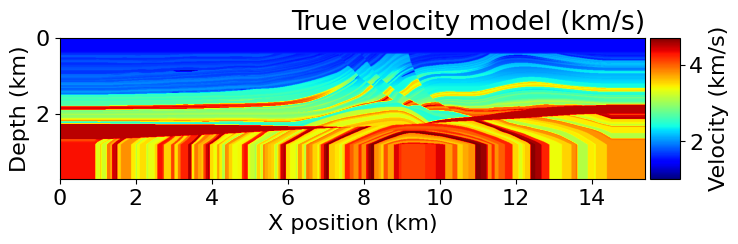

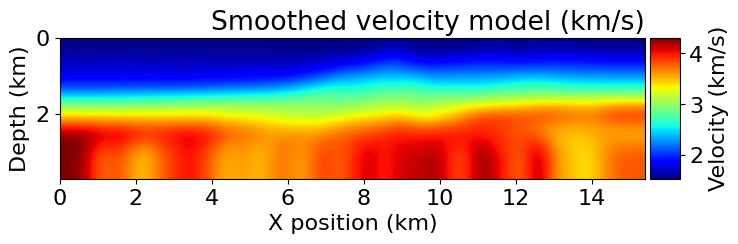

In [90]:
plt.title('True velocity model (km/s)', loc='right')
plot_velocity(model)
plt.title('Smoothed velocity model (km/s)', loc='right')
plot_velocity(model_sm)

In [7]:
## infosssss of model
print(model.domain_size)
print(model.critical_dt)
print(model.damp)
print(model.dim)
print(model.dm)
print(model.dt_scale)
print(model.grid)
print(model.m)
print(model.fs)
print(model.dtype)

(15400.0, 3700.0)
1.18
damp(x, y)
2
dm(x, y)
1
Grid[extent=(17200.0, 5500.0), shape=(1721, 551), dimensions=(x, y)]
vp(x, y)**(-2)
False
<class 'numpy.float32'>


### Acquisition geometry

In [91]:
# 定义源和接收器的位置
nsrc = 3
src_loc = np.empty((nsrc, 2), dtype=np.float32)
# src_loc[:, 0] = np.linspace(1000, model.domain_size[0] - 1000, nsrc) # starts from 1000 grid = 100m = 1km
src_loc[:, 0] = np.linspace(1000, 15000, nsrc) 
src_loc[:, 1] = -10  # Depth at 100m

nrcv = 101
rcv_loc = np.empty((nrcv, 2), dtype=np.float32)
# rcv_loc[:, 0] = np.linspace(0, model.domain_size[0], nrcv)
rcv_loc[:, 0] = np.linspace(100, 17000, nrcv)
rcv_loc[:, 1] = -100 # Depth at 100m which is 1000 grid

# 时间轴
t0 = 0.     # Shot records starts at 0.0
tn = 2000.  # Shot records last 3.0 second (3000 ms)
f0 = 0.005  # Source peak frequency is 5Hz (0.005 kHz)
dt = model.critical_dt
time = TimeAxis(start=t0, stop=tn, step=dt)

# 创建几何对象
geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
geom_sm = AcquisitionGeometry(model_sm, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

# 定义波场
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2, save=time.num)

# PDE 方程
pde = u.dt2 - (1/model.m) * u.laplace + (1/model.m) * model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping


In [92]:
geom_all.src_positions

array([[ 1.0e+03, -1.0e+01],
       [ 8.0e+03, -1.0e+01],
       [ 1.5e+04, -1.0e+01]], dtype=float32)

In [97]:
geom_all.grid

Grid[extent=(17200.0, 5500.0), shape=(1721, 551), dimensions=(x, y)]

In [98]:
# infosssss of geom
print(dt)
print("source positions:", geom_all.src_positions) ## position of grids
# print("receiver positions:", geom_all.rec_positions)
print(geom_all.adj_src)
print(geom_all.dt)
print(geom_all.grid)
print(geom_all.interpolation)
print(geom_all.model)
print(geom_all.f0)
print(geom_all.nt)
print(geom_all.new_src)

Model is kept for backward compatibility but should not beobtained from the geometry


1.18
source positions: [[ 1.0e+03 -1.0e+01]
 [ 8.0e+03 -1.0e+01]
 [ 1.5e+04 -1.0e+01]]
rec(time, p_rec)
1.18
Grid[extent=(17200.0, 5500.0), shape=(1721, 551), dimensions=(x, y)]
linear
0.005
1696
<bound method AcquisitionGeometry.new_src of <examples.seismic.utils.AcquisitionGeometry object at 0x16ca220d0>>


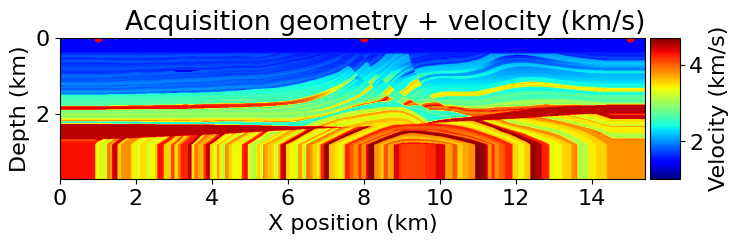

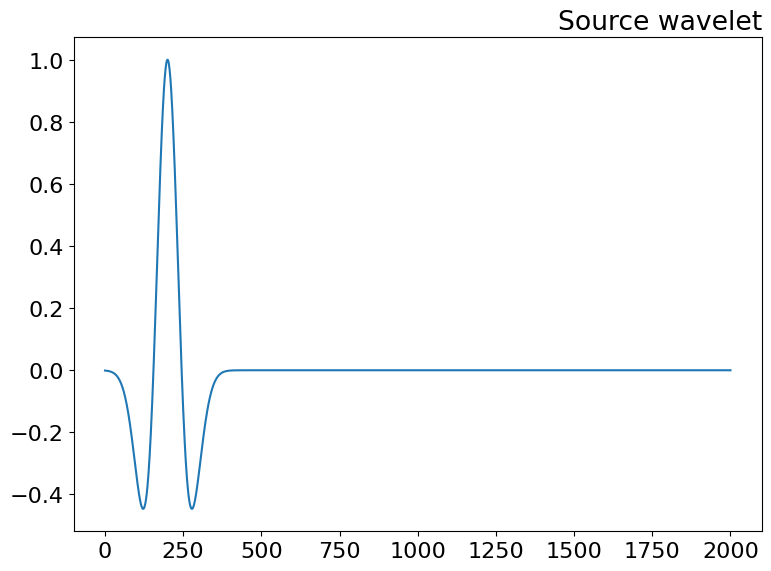

In [94]:
# Plot acquisition geometry overlaid with true Vp
plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plot_velocity(model, source=src_loc, receiver=rcv_loc[::4]); # Plot every one in four receivers.

# Plot source wavelet
plt.plot(geom_all.src.time_values, geom_all.src.data[:, 0])
plt.title('Source wavelet', loc='right')
plt.tight_layout(); plt.show()

### Forward modeling

In [95]:
import time as pytime
# Serial modeling function
def forward_modeling_single_source(model, src_index):
    # 定义源和接收器的位置
    nsrc = 3
    src_loc = np.empty((nsrc, 2), dtype=np.float32)
    src_loc[:, 0] = np.linspace(1000, 15000, nsrc)[src_index]
    src_loc[:, 1] = 100

    # 创建几何对象
    geom_all = AcquisitionGeometry(model, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')
    # geom_sm = AcquisitionGeometry(model_sm, rcv_loc, src_loc, t0, tn, f0=f0, src_type='Ricker')

    # 定义波场
    u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2, save=time.num)

    # PDE 方程
    pde = u.dt2 - (1/model.m) * u.laplace + (1/model.m) * model.damp * u.dt
    stencil = Eq(u.forward, solve(pde, u.forward))

    # 创建 Ricker 源并注入波场
    src = geom_all.src
    src_term = src.inject(field=u.forward, expr=src * dt**2 * model.m)

    # 创建接收器并插值波场
    rec = Receiver(name='rec', npoint=nrcv, grid=model.grid, coordinates=rcv_loc, time_range=time)
    rec_term = rec.interpolate(expr=u.forward)

    # Create operator and execute
    op_fwd = Operator([stencil] + src_term + rec_term)

    # Calculate running time
    start_time = pytime.time()
    op_fwd(dt=dt)
    end_time = pytime.time()
    running_time = end_time - start_time
    print(f"Running Time: {running_time:.2f} seconds")
    
    return rec, u, src_loc

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on ph

Running Time: 3.40 seconds


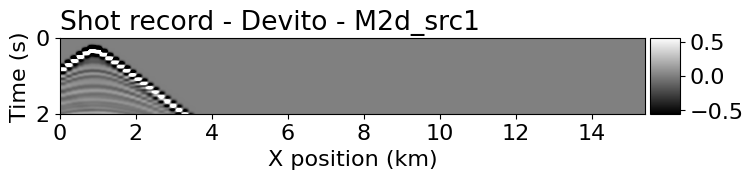

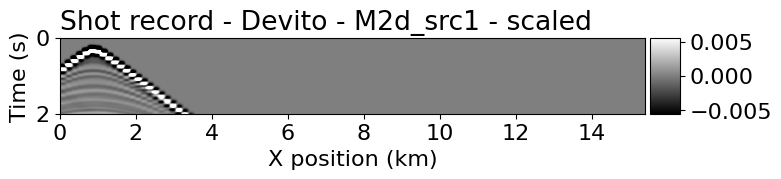

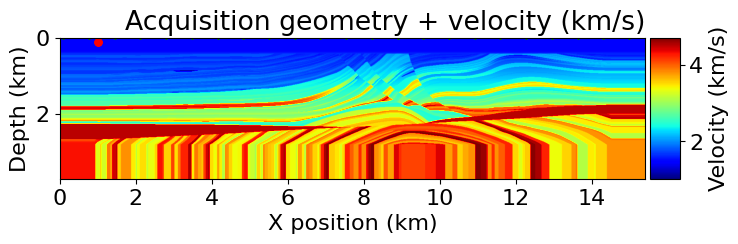

<class 'devito.data.data.Data'>


In [96]:
#Pick the first one source
isrc = 0
rec1, u1, src_loc1 = forward_modeling_single_source(model, src_index=isrc)
# rec1 = rec1.data * (1/(model1.spacing[0]**2))
# print(rec1.data[:-1, :])
# print(rec1.data[:-1, :].data.shape)
# print("min:",np.min(rec1.data))
# print("max:",np.max(rec1.data))

# print(rec1.data)

# plot the shot record
plt.title('Shot record - Devito - M2d_src1', loc='left')
plot_shotrecord(rec1.data, model, t0, tn)

# plot the shot record
plt.title('Shot record - Devito - M2d_src1 - scaled', loc='left')
plot_shotrecord(rec1.data * (1/(spacing[0]**2)), model, t0, tn)

plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plot_velocity(model, source=src_loc1, receiver=rcv_loc[::4]); # Plot every one in four receivers

# Save rec1 as a .dat file
recv1 = rec1.data * (1/(spacing[0]**2))
print(type(recv1))
np.savetxt("rec_ex2_devito_src1.dat", recv1[:-1, :])

In [99]:
recv1

Data([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      ...,
      [-1.6437736e-05,  1.4301942e-03,  1.8946450e-03, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 5.4364740e-05,  1.4842447e-03,  1.8877527e-03, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
      [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

<class 'memoryview'>
-3.2859468
5.564962
(1696, 101)
1.18
-0.032859467
0.05564962


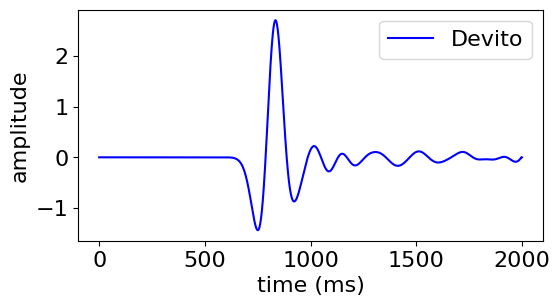

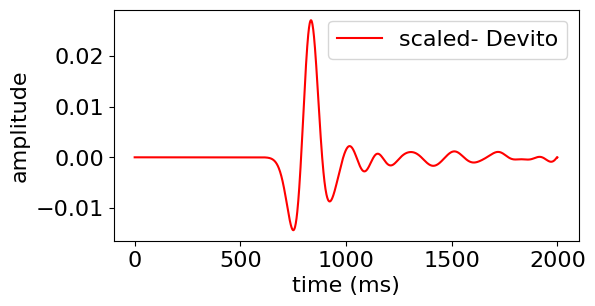

In [87]:
# Plot trace
print(type(recv1.data))
print(np.min(rec1.data))
print(np.max(rec1.data))
print(rec1.data.shape)
print(dt)
# print(rec1.data * (1/(spacing[0]**2)))
print(np.min(rec1.data * (1/(spacing[0]**2))))
print(np.max(rec1.data * (1/(spacing[0]**2))))


plt.figure(figsize=(6,3))
plt.plot( np.arange(rec1.data.shape[0]) * 1.18, rec1.data[:, 0], label='Devito', color='blue')
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()

plt.figure(figsize=(6,3))
scaled_data = rec1.data * (1 / (spacing[0] ** 2))
plt.plot(np.arange(scaled_data.shape[0]) * 1.18, scaled_data[:, 0], label='scaled- Devito', color='red')
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on ph

Running Time: 3.35 seconds


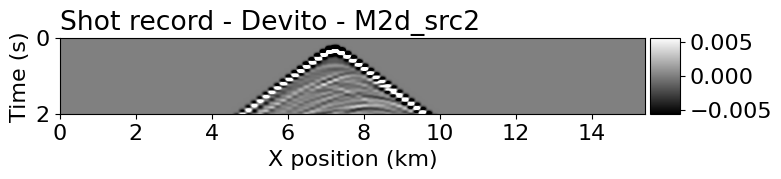

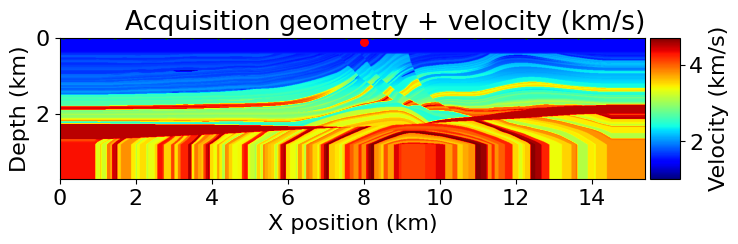

In [101]:
#Pick the first one source
isrc = 1
rec2, u2, src_loc2 = forward_modeling_single_source(model, src_index=isrc)
# rec1 = rec.data * (1/(model1.spacing[0]**2))
# print(rec1[:-1, :])
# print(rec1[:-1, :].data.shape)
# print("min:",np.min(rec1))
# print("max:",np.max(rec1))

# Plot the shot record for the second source
plt.title('Shot record - Devito - M2d_src2', loc='left')
plot_shotrecord(rec2.data * (1/(spacing[0]**2)), model, t0, tn)

plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plot_velocity(model, source=src_loc2, receiver=rcv_loc[::4]); # Plot every one in four receivers

# recv2 = rec2.data * (1/(spacing[0]**2))
# print(type(recv2.data))
# # Save rec1 as a .dat file
# np.savetxt("M2d_shotrecord_src2_devito.dat", recv2.data[:-1, :])

Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on physical device, this will start swapping
Trying to allocate more memory for symbol u than available on ph

Running Time: 3.26 seconds


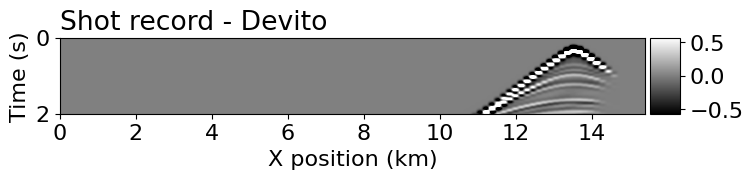

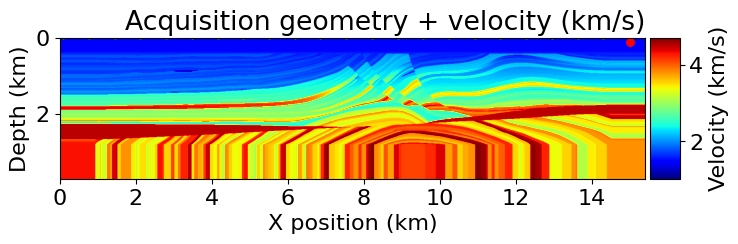

In [102]:
#Pick the first one source
isrc = 2
rec3, u3, src_loc3 = forward_modeling_single_source(model, src_index=isrc)
# rec1 = rec.data * (1/(model1.spacing[0]**2))
# print(rec1[:-1, :])
# print(rec1[:-1, :].data.shape)s
# print("min:",np.min(rec1))
# print("max:",np.max(rec1))

# plot the shot record for the third source
plt.title('Shot record - Devito', loc='left')
plot_shotrecord(rec3.data, model, t0, tn)

plt.title('Acquisition geometry + velocity (km/s)', loc='right')
plot_velocity(model, source=src_loc3, receiver=rcv_loc[::4]); # Plot every one in four receivers

# recv3 = rec3.data * (1/(spacing[0]**2))
# # Save rec1 as a .dat file
# np.savetxt("M2d_shotrecord_src3_devito.dat", recv3.data[:-1, :])

### Plot pressure fields

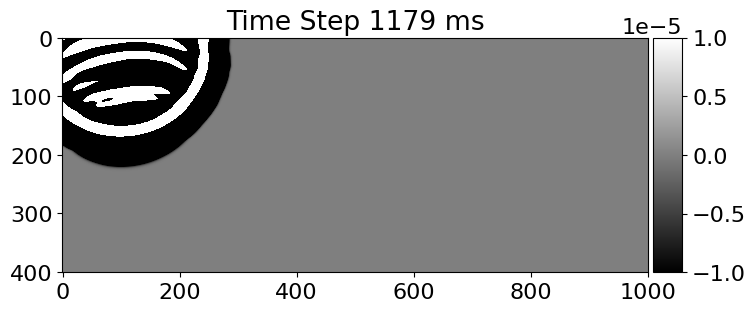

In [87]:
from examples.seismic import plot_image
# Assume the model, time axis, and wavefield data are properly defined
tmax = time.num - 1
times = [int(tmax/10), int(tmax/8), int(tmax/7), int(tmax/6), int(tmax/5), int(tmax/4)]

time_index = 1000
plt.title(f"Time Step {int(time_index * dt)} ms")
plot_image(u1.data[time_index, nbl:-nbl, nbl:-nbl], cmap="gray", vmin=-1e-5, vmax=1e-5)

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_14112/887837770.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


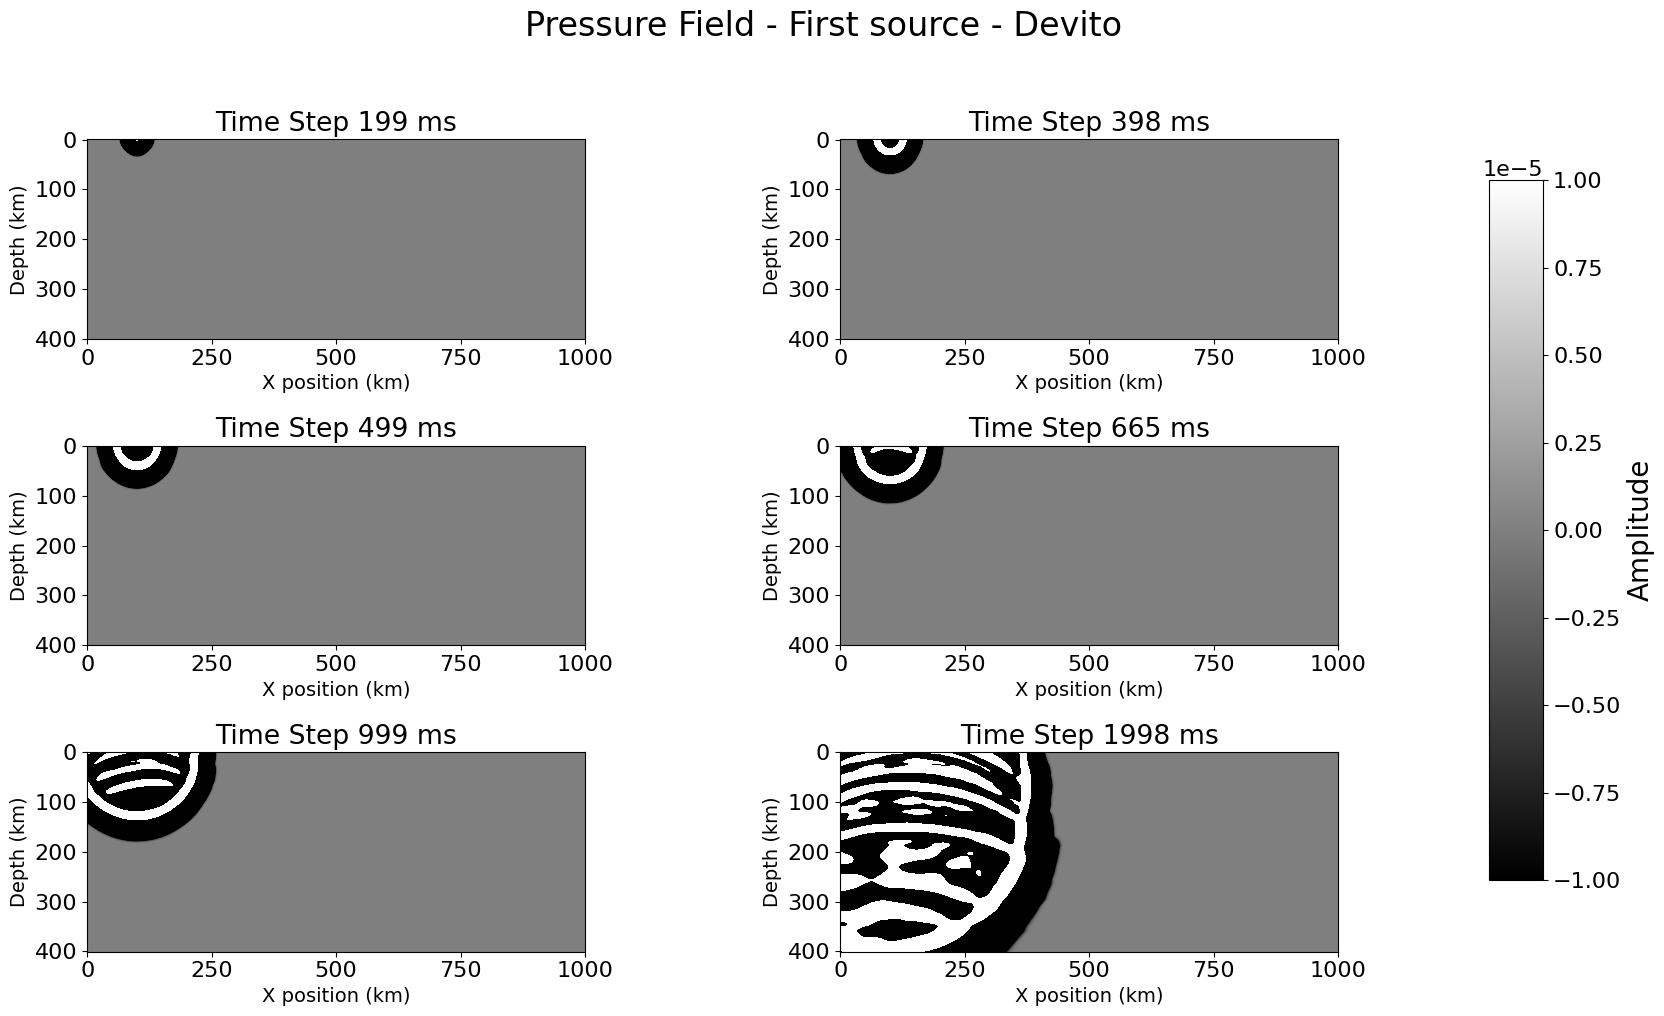

In [43]:
# from examples.seismic import plot_image
# import matplotlib.pyplot as plt

# # Assume the model, time axis, and wavefield data are properly defined
# tmax =  (tn - t0 ) / dt
# times = [int(tmax/10), int(tmax/5), int(tmax/4), int(tmax/3), int(tmax/2), int(tmax/1)]

# # Set the overall size of the figure
# fig, axes = plt.subplots(1, 4, figsize=(18, 10))

# # Create six subplots
# for i, ax in enumerate(axes.flat):
#     time_index = times[i]
#     ax.set_ylabel('Depth (km)', fontsize=14)
#     ax.set_xlabel('X position (km)', fontsize=14)
#     ax.set_title(f"Time Step {int(time_index * dt)} ms")
#     image = u1.data[time_index, nbl:-nbl, nbl:-nbl]
#     im = ax.imshow(image, cmap="gray", vmin=-1e-5, vmax=1e-5)

#     # ax.set_xticklabels([f"{int(x)}" for x in np.linspace(0., model.domain_size[0]/spacing[0], num=6)])
#     # ax.set_yticklabels([f"{int(y)}" for y in np.linspace(0., model.domain_size[1]/spacing[1], num=6)])
#     # Set x and y ticks
#     yticks = np.linspace(0, model.domain_size[0]/spacing[0], num=5)
#     xticks = np.linspace(0, model.domain_size[1]/spacing[1], num=5)
#     ax.set_xticks(xticks)
#     ax.set_yticks(yticks)
#     ax.set_xticklabels([f"{int(x)}" for x in xticks])
#     ax.set_yticklabels([f"{int(y)}" for y in yticks])

# # Add a unified colorbar
# fig.subplots_adjust(right=0.85)  
# cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7]) 
# cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.005)
# cbar.set_label('Amplitude', fontsize=20)

# fig.suptitle('Pressure Field - First source - Devito', fontsize=24, y=1.02)
# plt.tight_layout(rect=[0, 0, 0.85, 1])
# plt.show()


from examples.seismic import plot_image
import matplotlib.pyplot as plt

# Assume the model, time axis, and wavefield data are properly defined
tmax =  (tn - t0 ) / dt
times = [int(tmax/10), int(tmax/5), int(tmax/4), int(tmax/3), int(tmax/2), int(tmax/1)]

# Set the overall size of the figure
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

# Create six subplots
for i, ax in enumerate(axes.flat):
    time_index = times[i]
    ax.set_ylabel('Depth (km)', fontsize=14)
    ax.set_xlabel('X position (km)', fontsize=14)
    ax.set_title(f"Time Step {int(time_index * dt)} ms")
    image = np.transpose(u1.data[time_index, nbl:-nbl, nbl:-nbl])
    im = ax.imshow(image, cmap="gray", vmin=-1e-5, vmax=1e-5)

    # ax.set_xticklabels([f"{int(x)}" for x in np.linspace(0., model.domain_size[0]/spacing[0], num=6)])
    # ax.set_yticklabels([f"{int(y)}" for y in np.linspace(0., model.domain_size[1]/spacing[1], num=6)])
    # Set x and y ticks
    xticks = np.linspace(0, model.domain_size[0]/spacing[0], num=5)
    yticks = np.linspace(0, model.domain_size[1]/spacing[1], num=5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    ax.set_yticklabels([f"{int(y)}" for y in yticks])

# Add a unified colorbar
fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.005)
cbar.set_label('Amplitude', fontsize=20)

fig.suptitle('Pressure Field - First source - Devito', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_13396/3045526842.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


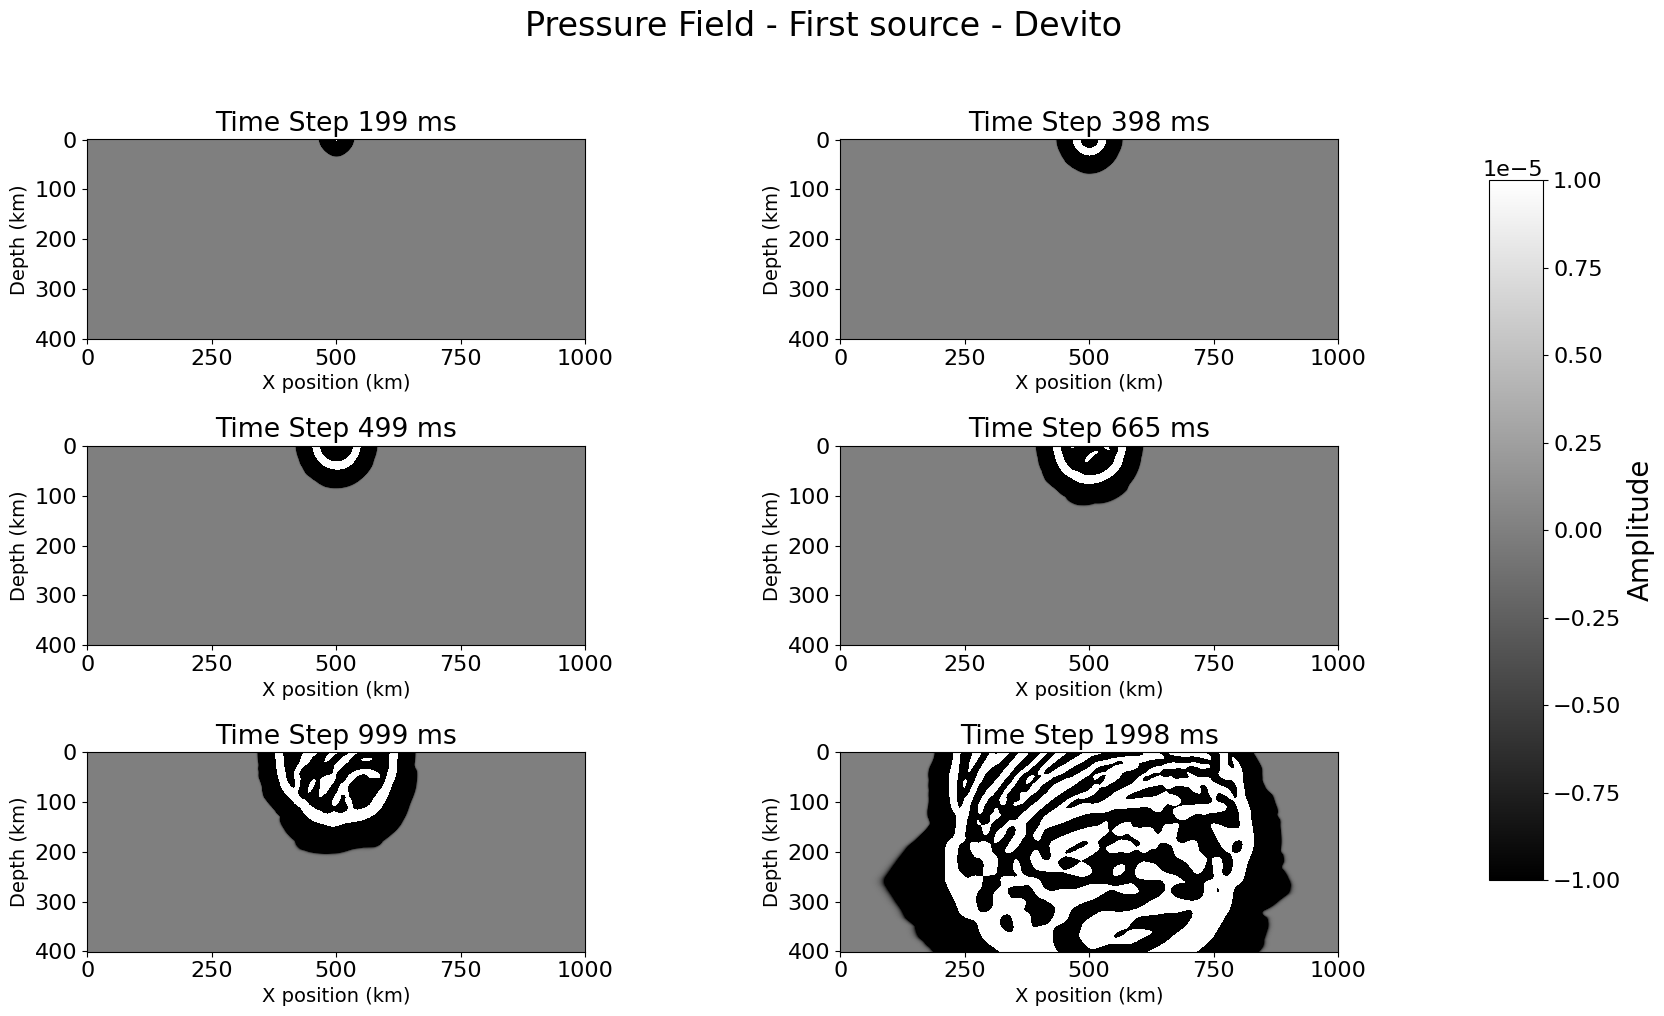

In [125]:
from examples.seismic import plot_image
import matplotlib.pyplot as plt

# Assume the model, time axis, and wavefield data are properly defined
tmax =  (tn - t0 ) / dt
times = [int(tmax/10), int(tmax/5), int(tmax/4), int(tmax/3), int(tmax/2), int(tmax/1)]

# Set the overall size of the figure
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

# Create six subplots
for i, ax in enumerate(axes.flat):
    time_index = times[i]
    ax.set_ylabel('Depth (km)', fontsize=14)
    ax.set_xlabel('X position (km)', fontsize=14)
    ax.set_title(f"Time Step {int(time_index * dt)} ms")
    image = np.transpose(u2.data[time_index, nbl:-nbl, nbl:-nbl])
    im = ax.imshow(image, cmap="gray", vmin=-1e-5, vmax=1e-5)

    # ax.set_xticklabels([f"{int(x)}" for x in np.linspace(0., model.domain_size[0]/spacing[0], num=6)])
    # ax.set_yticklabels([f"{int(y)}" for y in np.linspace(0., model.domain_size[1]/spacing[1], num=6)])
    # Set x and y ticks
    xticks = np.linspace(0, model.domain_size[0]/spacing[0], num=5)
    yticks = np.linspace(0, model.domain_size[1]/spacing[1], num=5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    ax.set_yticklabels([f"{int(y)}" for y in yticks])

# Add a unified colorbar
fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.005)
cbar.set_label('Amplitude', fontsize=20)

fig.suptitle('Pressure Field - First source - Devito', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

/var/folders/hx/g9tst_895vb2cxj5f1f0lghh0000gp/T/ipykernel_13396/4163437975.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


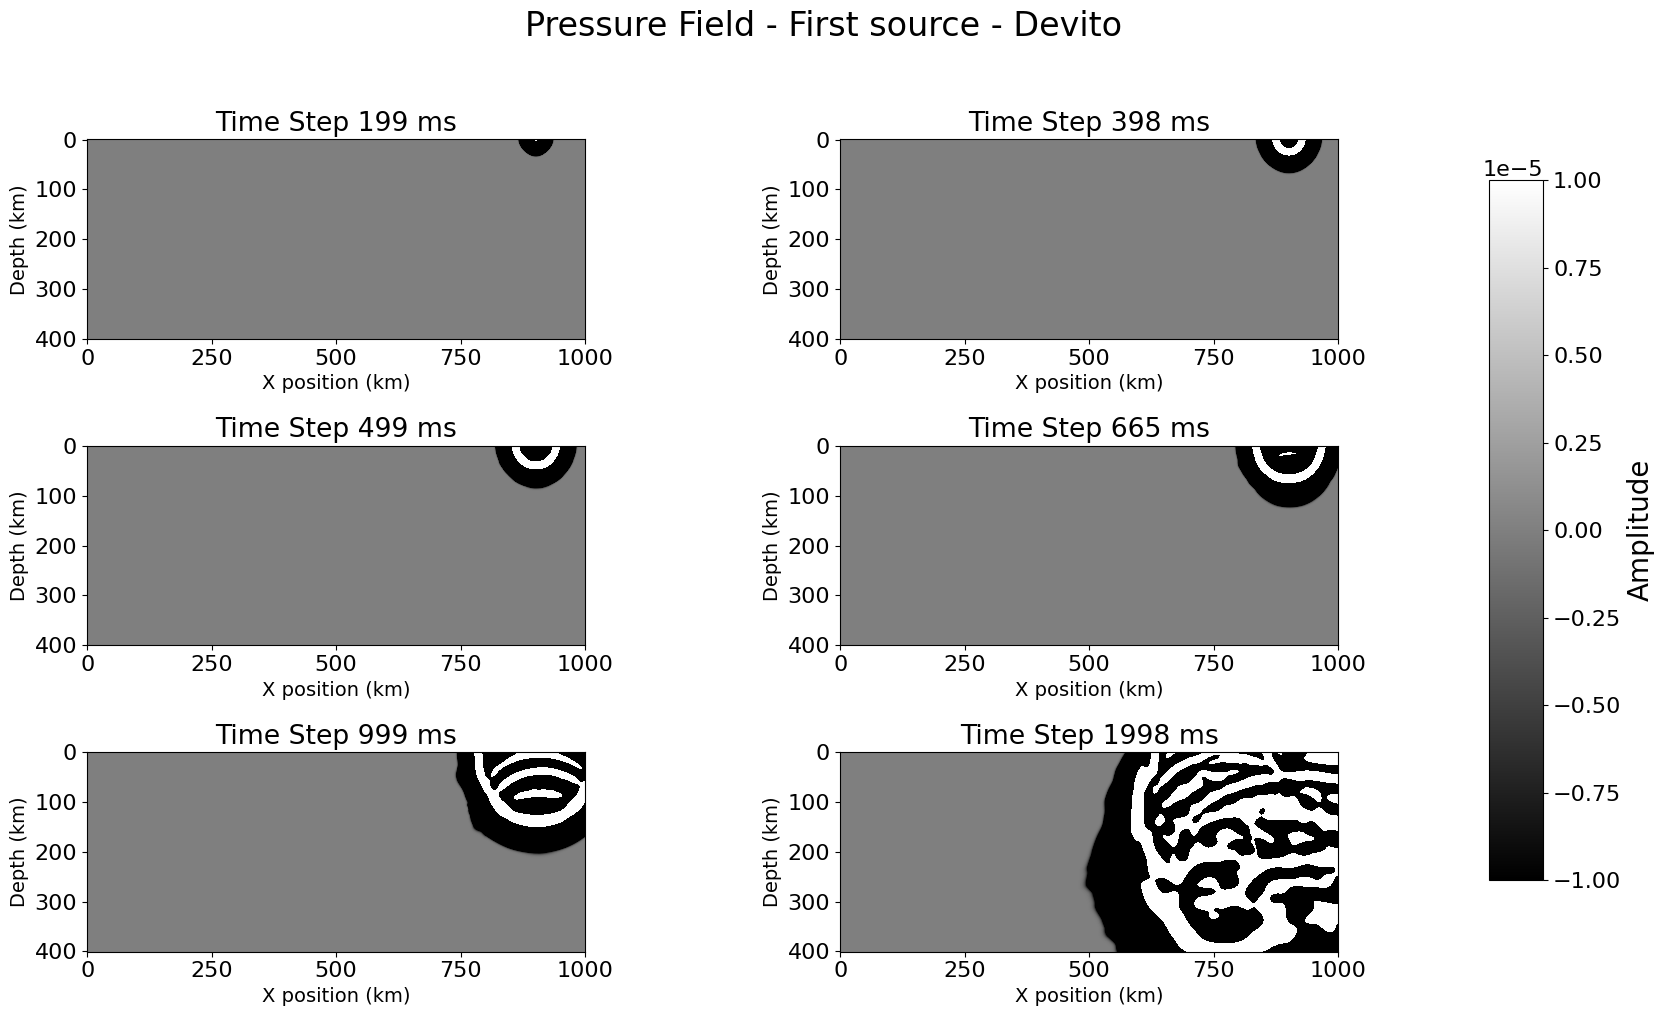

In [126]:
from examples.seismic import plot_image
import matplotlib.pyplot as plt

# Assume the model, time axis, and wavefield data are properly defined
tmax =  (tn - t0 ) / dt
times = [int(tmax/10), int(tmax/5), int(tmax/4), int(tmax/3), int(tmax/2), int(tmax/1)]

# Set the overall size of the figure
fig, axes = plt.subplots(3, 2, figsize=(18, 10))

# Create six subplots
for i, ax in enumerate(axes.flat):
    time_index = times[i]
    ax.set_ylabel('Depth (km)', fontsize=14)
    ax.set_xlabel('X position (km)', fontsize=14)
    ax.set_title(f"Time Step {int(time_index * dt)} ms")
    image = np.transpose(u3.data[time_index, nbl:-nbl, nbl:-nbl])
    im = ax.imshow(image, cmap="gray", vmin=-1e-5, vmax=1e-5)

    # ax.set_xticklabels([f"{int(x)}" for x in np.linspace(0., model.domain_size[0]/spacing[0], num=6)])
    # ax.set_yticklabels([f"{int(y)}" for y in np.linspace(0., model.domain_size[1]/spacing[1], num=6)])
    # Set x and y ticks
    xticks = np.linspace(0, model.domain_size[0]/spacing[0], num=5)
    yticks = np.linspace(0, model.domain_size[1]/spacing[1], num=5)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels([f"{int(x)}" for x in xticks])
    ax.set_yticklabels([f"{int(y)}" for y in yticks])

# Add a unified colorbar
fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7]) 
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', pad=0.005)
cbar.set_label('Amplitude', fontsize=20)

fig.suptitle('Pressure Field - First source - Devito', fontsize=24, y=1.02)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [107]:
print(u3.data.shape)
print(u3.data[100, nbl:-nbl, nbl:-nbl].shape)

(1696, 1721, 551)
(1541, 371)
